In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
from scib_metrics.benchmark import Benchmarker
import time
from pathlib import Path
import torch
import Concord as ccd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [3]:
proj_name = "human_pancreas_benchmarking"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
seed = 0
ccd.ul.set_seed(seed)

In [4]:
data_dir = Path("../data/pancreas/")
adata = sc.read(
    data_dir / "dataset.h5ad"
)
adata

AnnData object with n_obs × n_vars = 16382 × 18771
    obs: 'tech', 'celltype', 'size_factors', 'n_counts', 'cell_type', 'batch'
    var: 'n_cells', 'feature_name', 'hvg', 'hvg_score'
    uns: '_from_cache', 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_reference', 'dataset_summary', 'dataset_url', 'knn', 'normalization_id', 'pca_variance', 'var_names_all'
    obsm: 'X_pca'
    varm: 'pca_loadings'
    layers: 'counts', 'log_normalized', 'normalized'
    obsp: 'knn_connectivities', 'knn_distances'

In [5]:
adata.X = adata.layers["counts"].copy()
feature_list = ccd.ul.select_features(adata, n_top_features=3000, flavor='seurat_v3', normalize=False, log1p=False)
adata = adata[:, feature_list]
adata.X = adata.layers["log_normalized"].copy()
adata.obs['log_ncounts'] = np.log1p(adata.obs['n_counts'])

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...


/opt/anaconda3/envs/concord/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/ipykernel_55710/1441727171.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['log_ncounts'] = np.log1p(adata.obs['n_counts'])


Load previous results.

In [6]:
adata.obsm = ccd.ul.load_obsm_from_hdf5(Path('../save/dev_human_pancreas_benchmarking-Oct10/') / "obsm_human_pancreas_benchmarking_Oct10-1845.h5")
adata.obsm

AxisArrays with keys: Concord, Concord_UMAP, Concordant, Concordant-leiden, Concordant_UMAP, Harmony, Harmony_UMAP, LIGER, LIGER_UMAP, Scanorama, Scanorama_UMAP, Unintegrated, X_pca, X_umap, scANVI, scANVI_UMAP, scVI, scVI_UMAP

### No correction

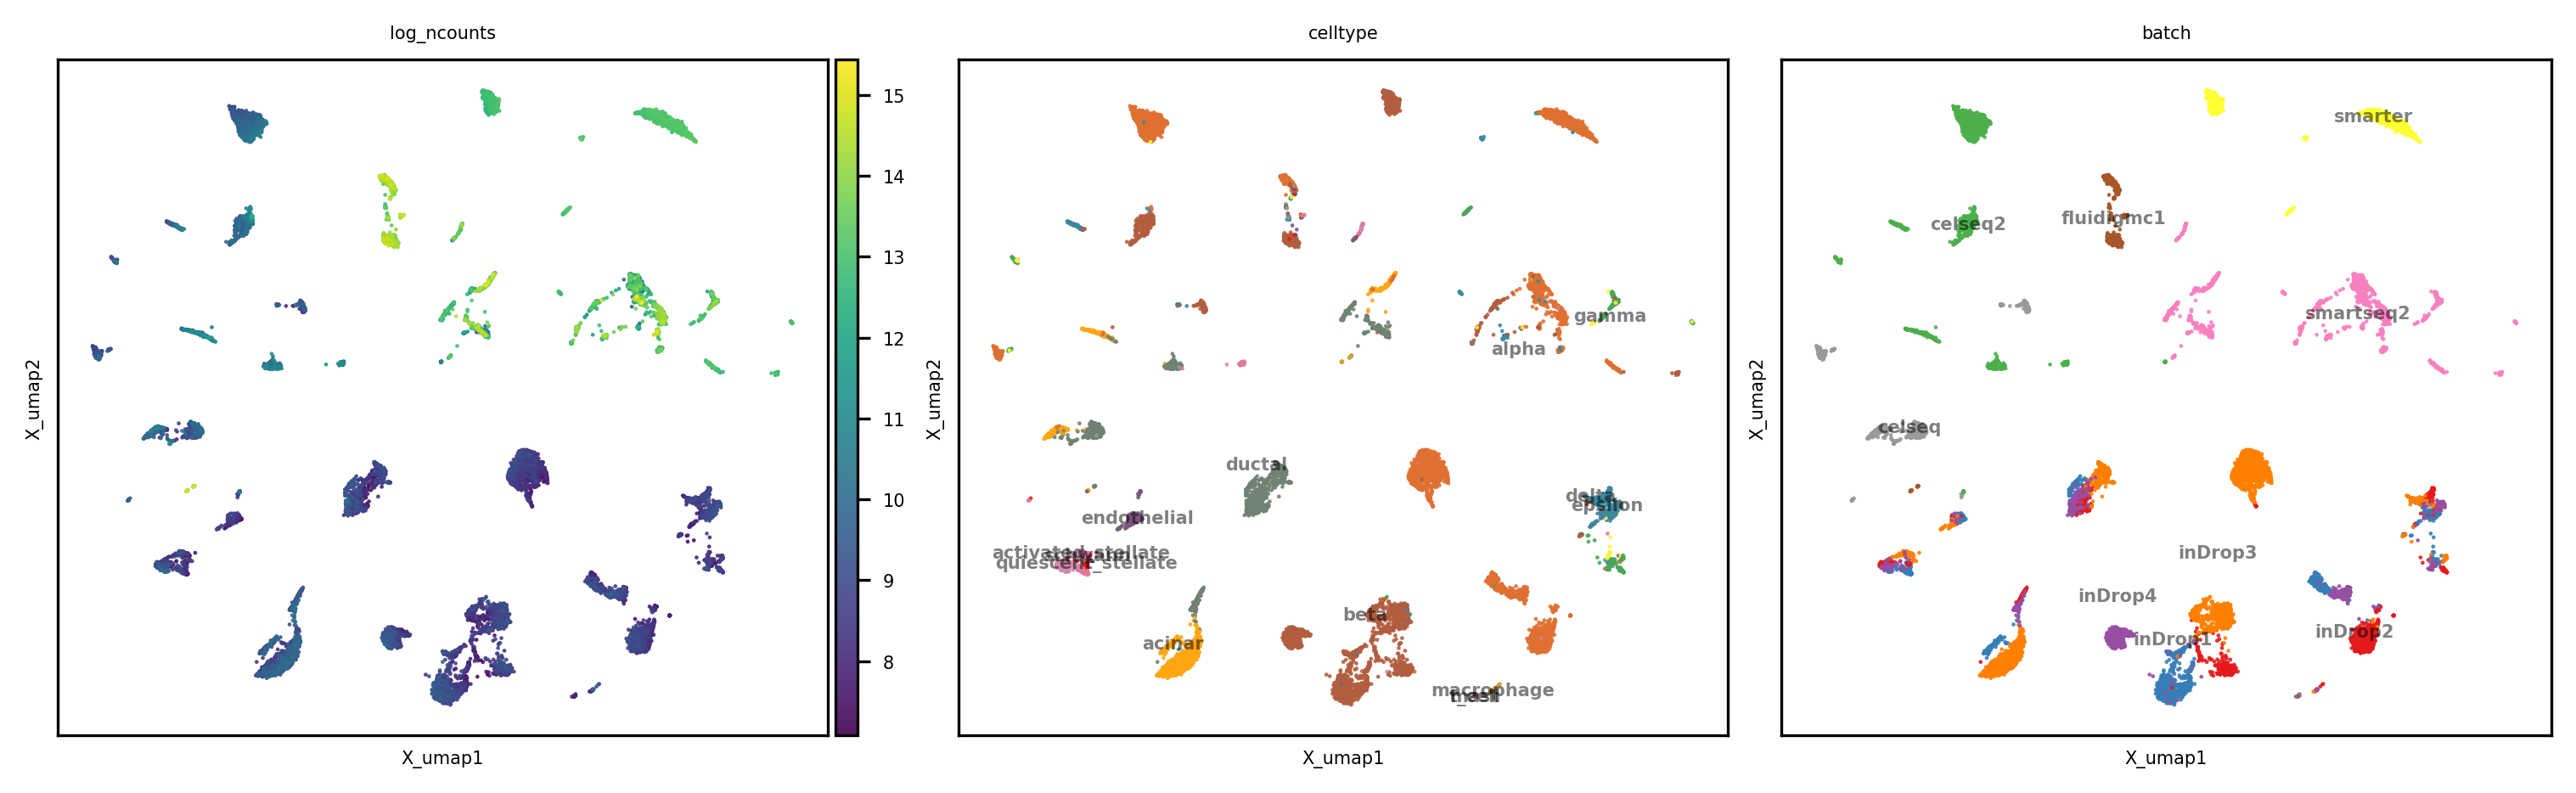

In [62]:
#sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
#sc.tl.umap(adata, min_dist=0.1)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
show_basis = 'X_umap'
show_cols = ['log_ncounts', 'celltype', 'batch']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Scanorama

In [22]:
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

Found 3000 genes among all datasets
[[0.         0.6547046  0.02037618 0.20185854 0.1374502  0.0189243
  0.03386454 0.03784861 0.3436255 ]
 [0.         0.         0.11128527 0.0547238  0.01218097 0.
  0.00690714 0.02546917 0.59212254]
 [0.         0.         0.         0.01253918 0.0031348  0.00626959
  0.0015674  0.63949843 0.03134796]
 [0.         0.         0.         0.         0.60041301 0.56943727
  0.35379893 0.01445534 0.01600413]
 [0.         0.         0.         0.         0.         0.42343387
  0.75058005 0.01798144 0.08352668]
 [0.         0.         0.         0.         0.         0.
  0.56715272 0.0074896  0.01420217]
 [0.         0.         0.         0.         0.         0.
  0.         0.1181888  0.12356101]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.58512064]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
Processing datasets (4, 6)
Processing datasets (0, 1)
Processing dat

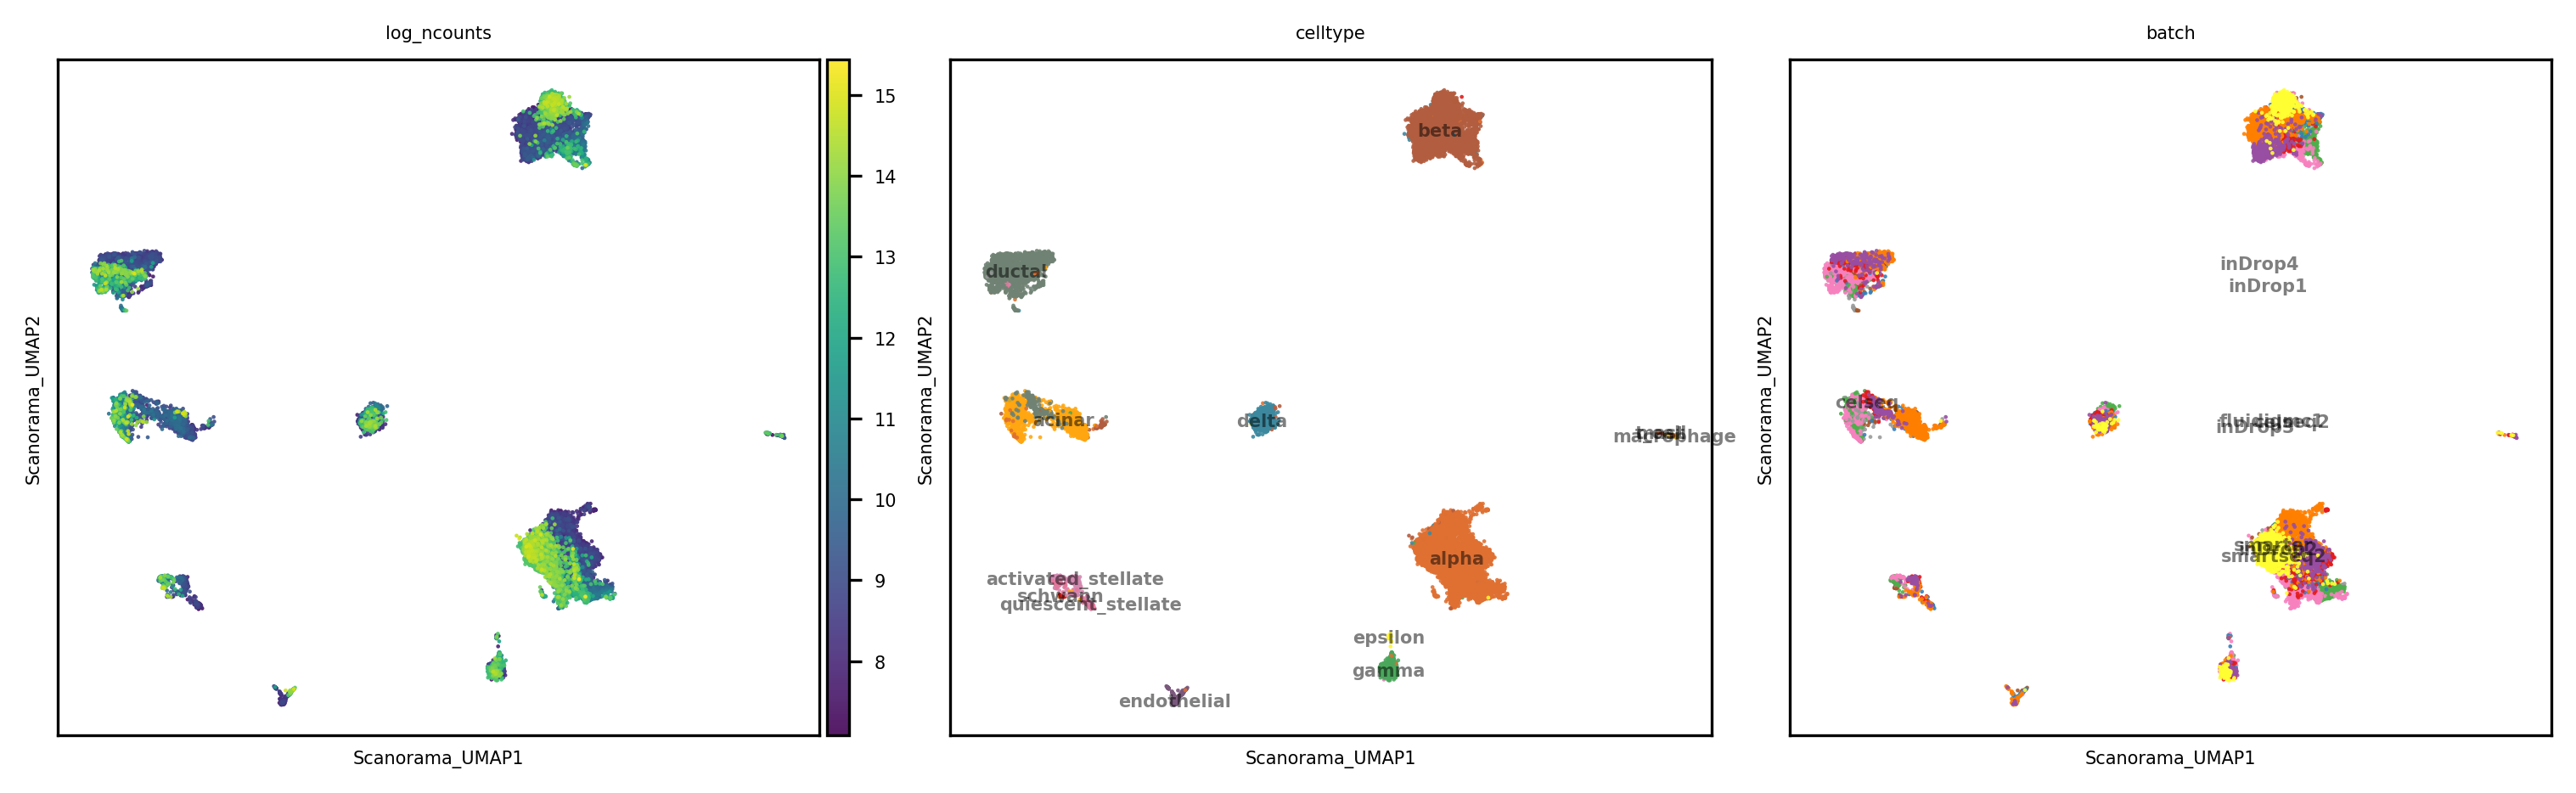

In [58]:
output_key = 'Scanorama'
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Liger

In [24]:
import pyliger
batch_cats = adata.obs.batch.cat.categories
bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)

liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)

output_key = 'LIGER'
adata.obsm[output_key] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm[output_key][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

100%|██████████| 30/30 [03:09<00:00,  6.32s/it]


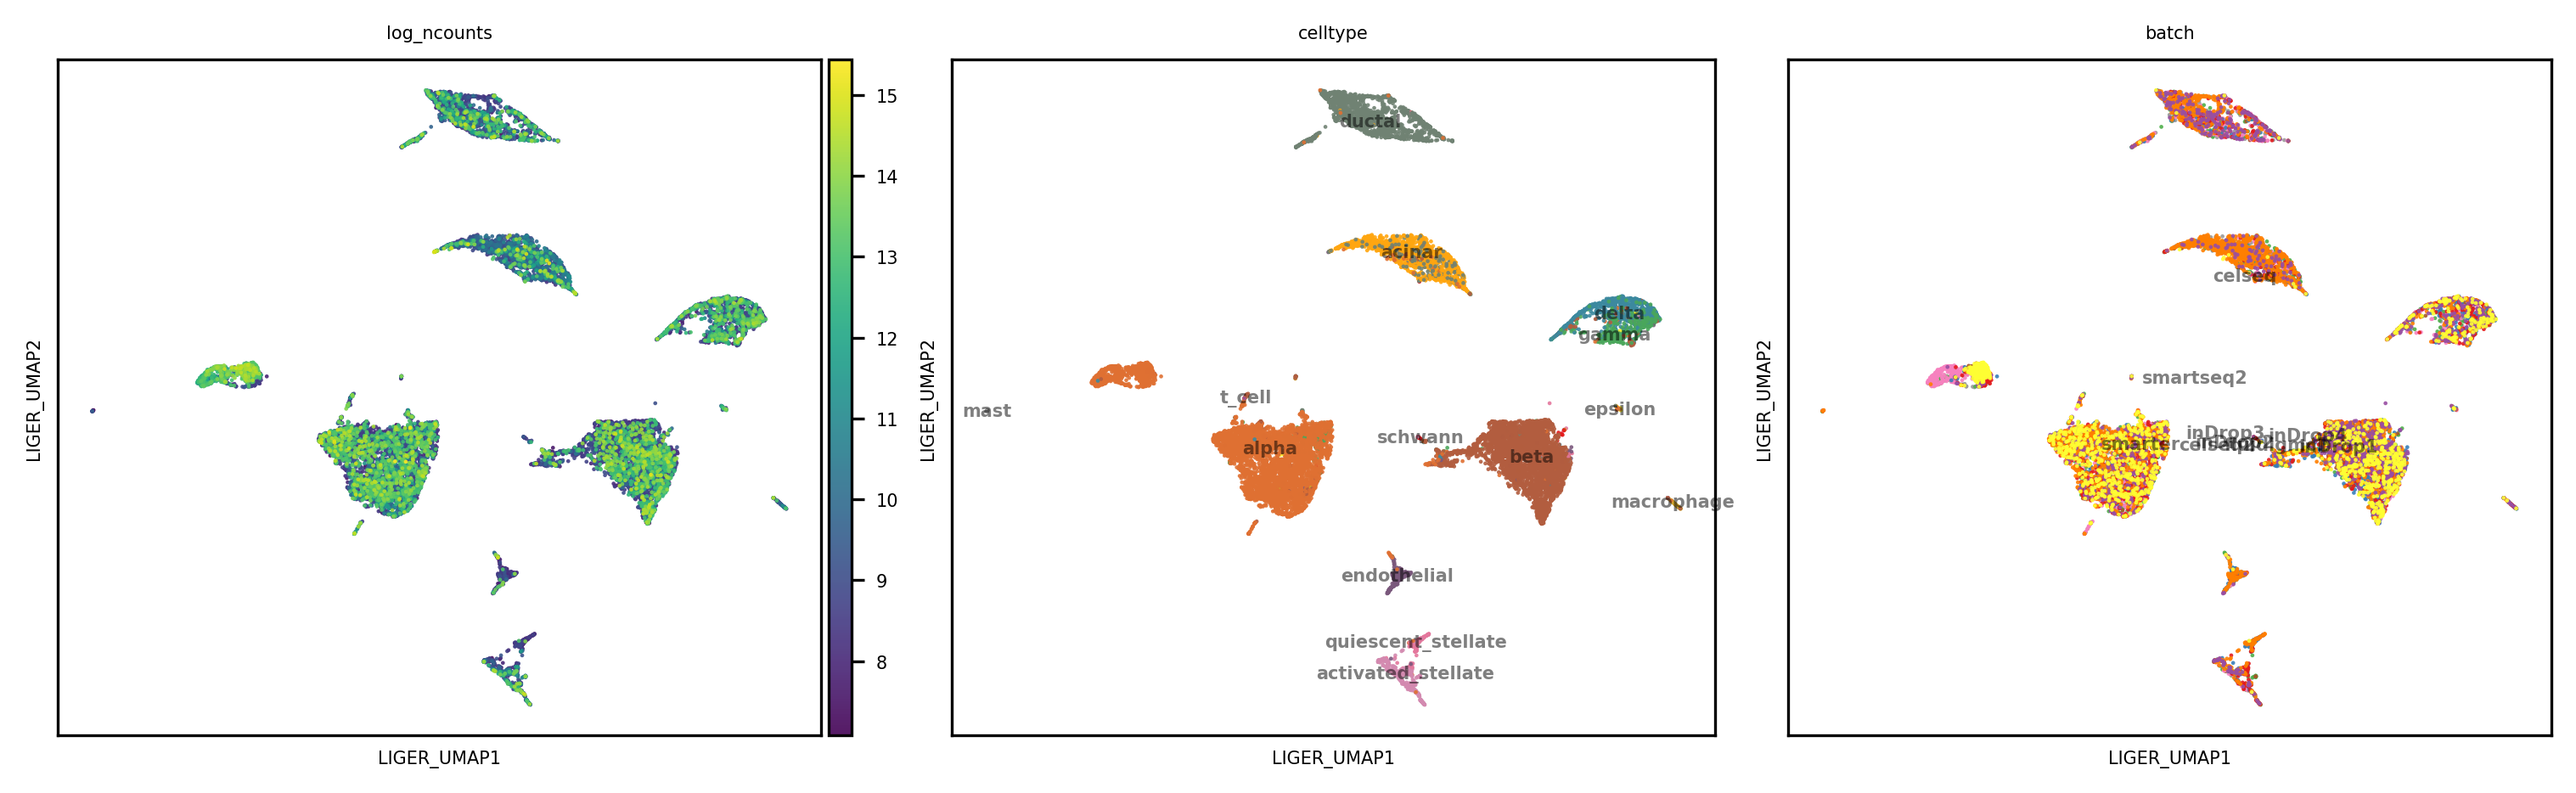

In [57]:
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'LIGER'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Harmony

In [26]:
from harmony import harmonize
output_key = 'Harmony'
adata.obsm[output_key] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


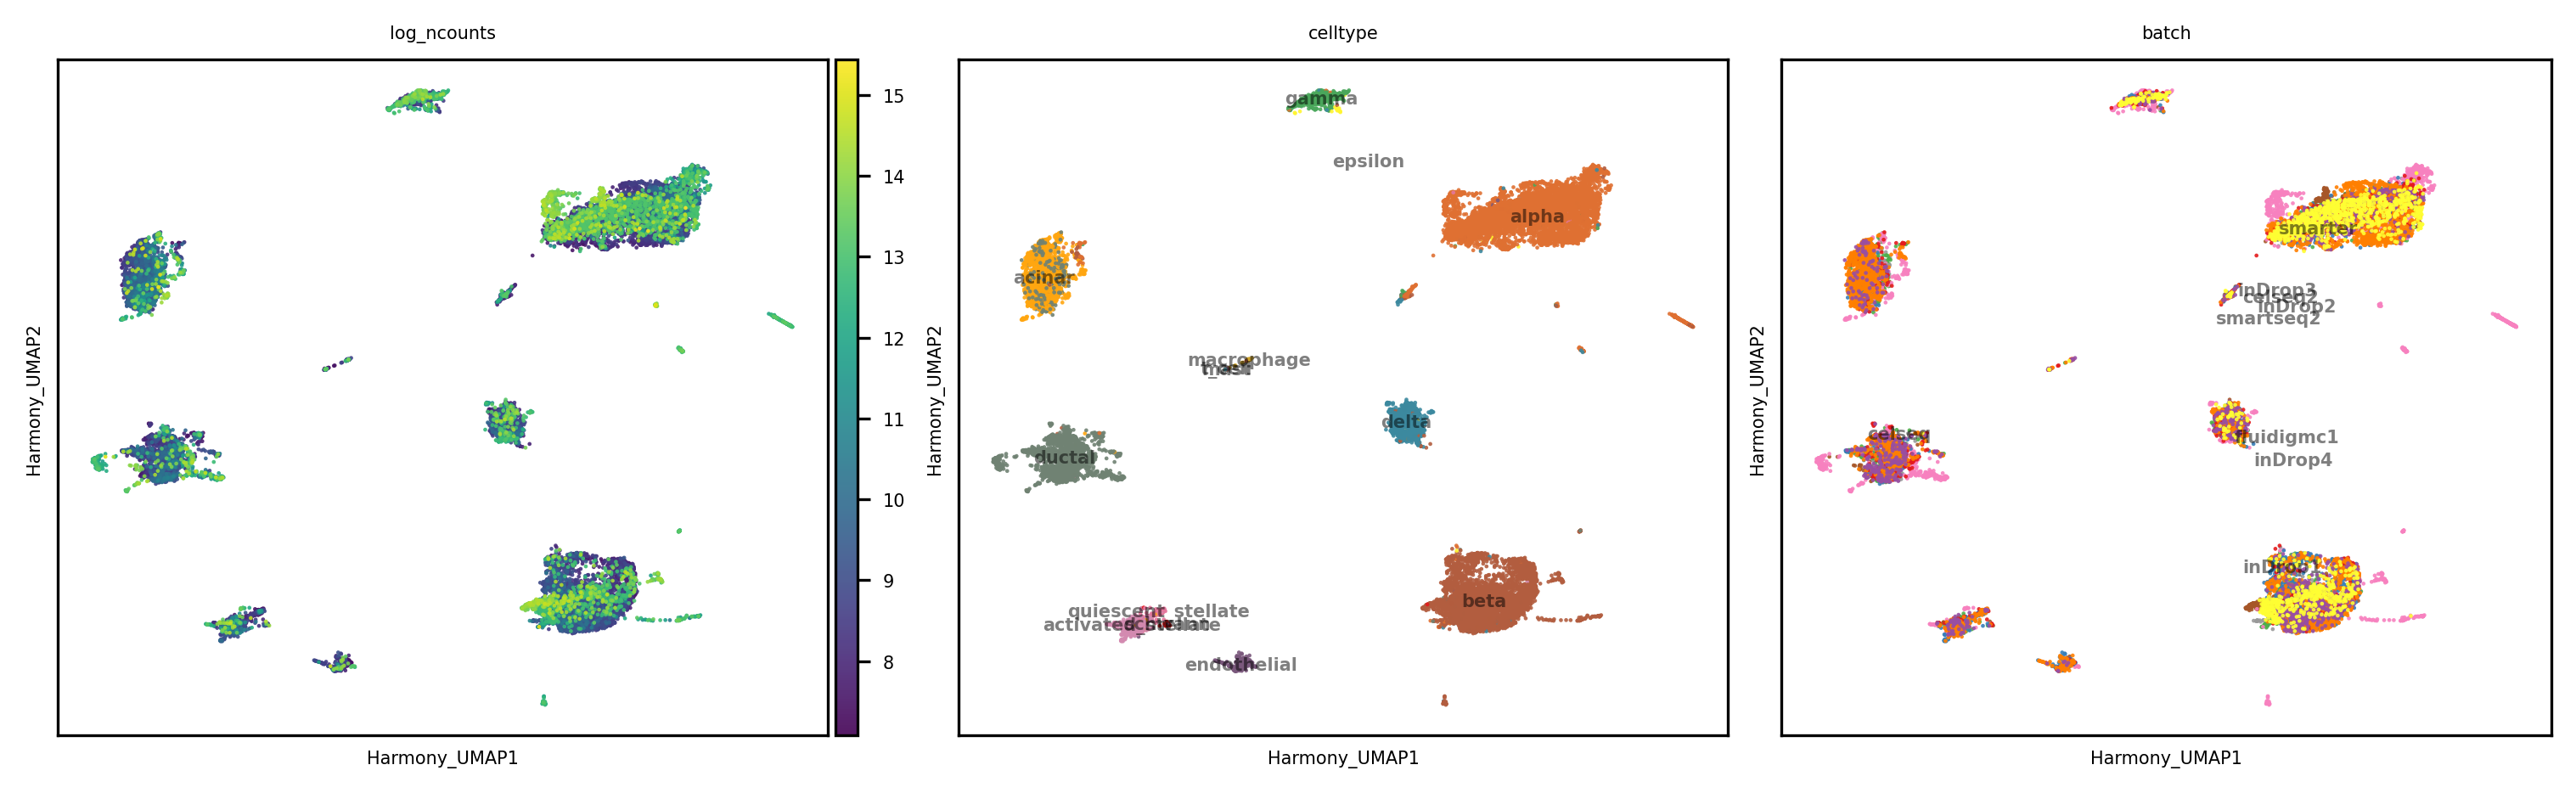

In [54]:
output_key = 'Harmony'
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scVI

In [28]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
output_key = 'scVI'
adata.obsm[output_key] = vae.get_latent_representation()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████| 400/400 [09:02<00:00,  1.36s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.59e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:02<00:00,  1.36s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.59e+3]


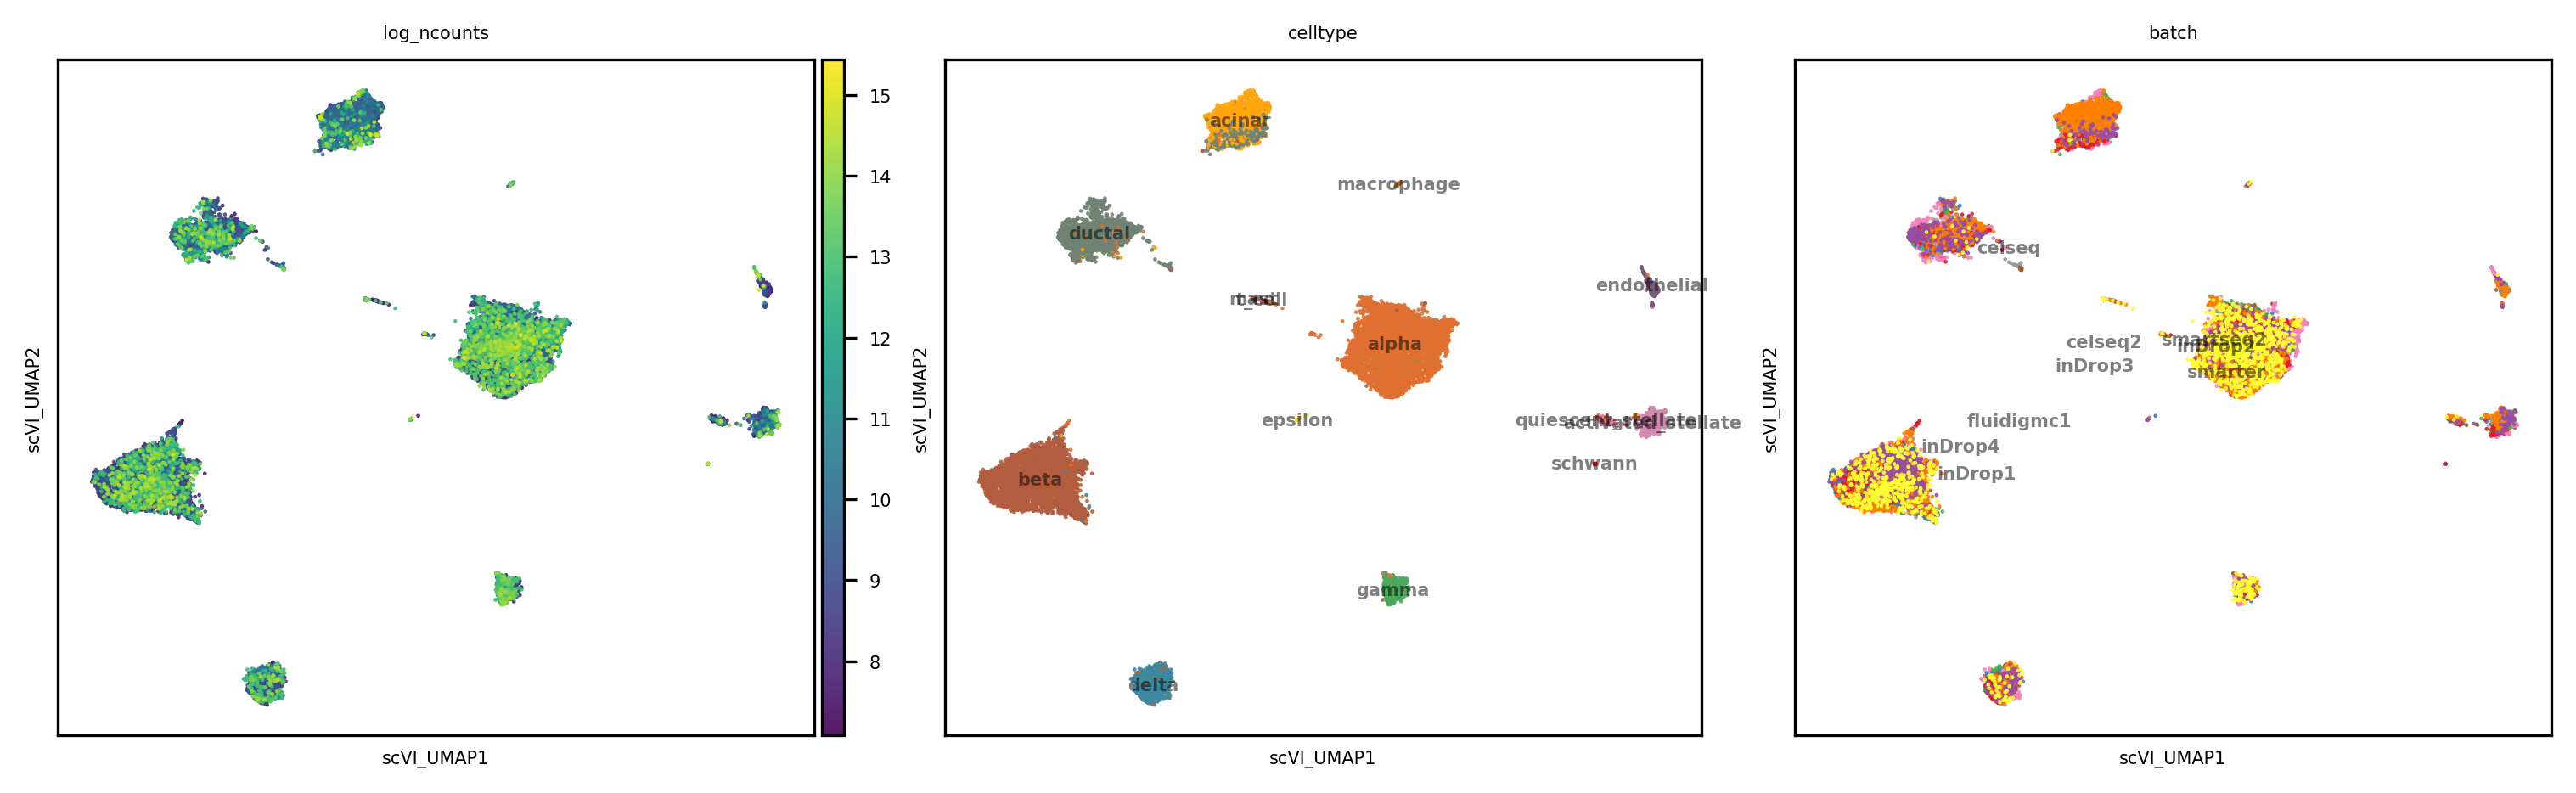

In [53]:
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'scVI'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### scANVI

In [30]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
output_key = 'scANVI'
adata.obsm[output_key] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 20/20: 100%|██████████| 20/20 [01:03<00:00,  3.06s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.57e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.57e+3]


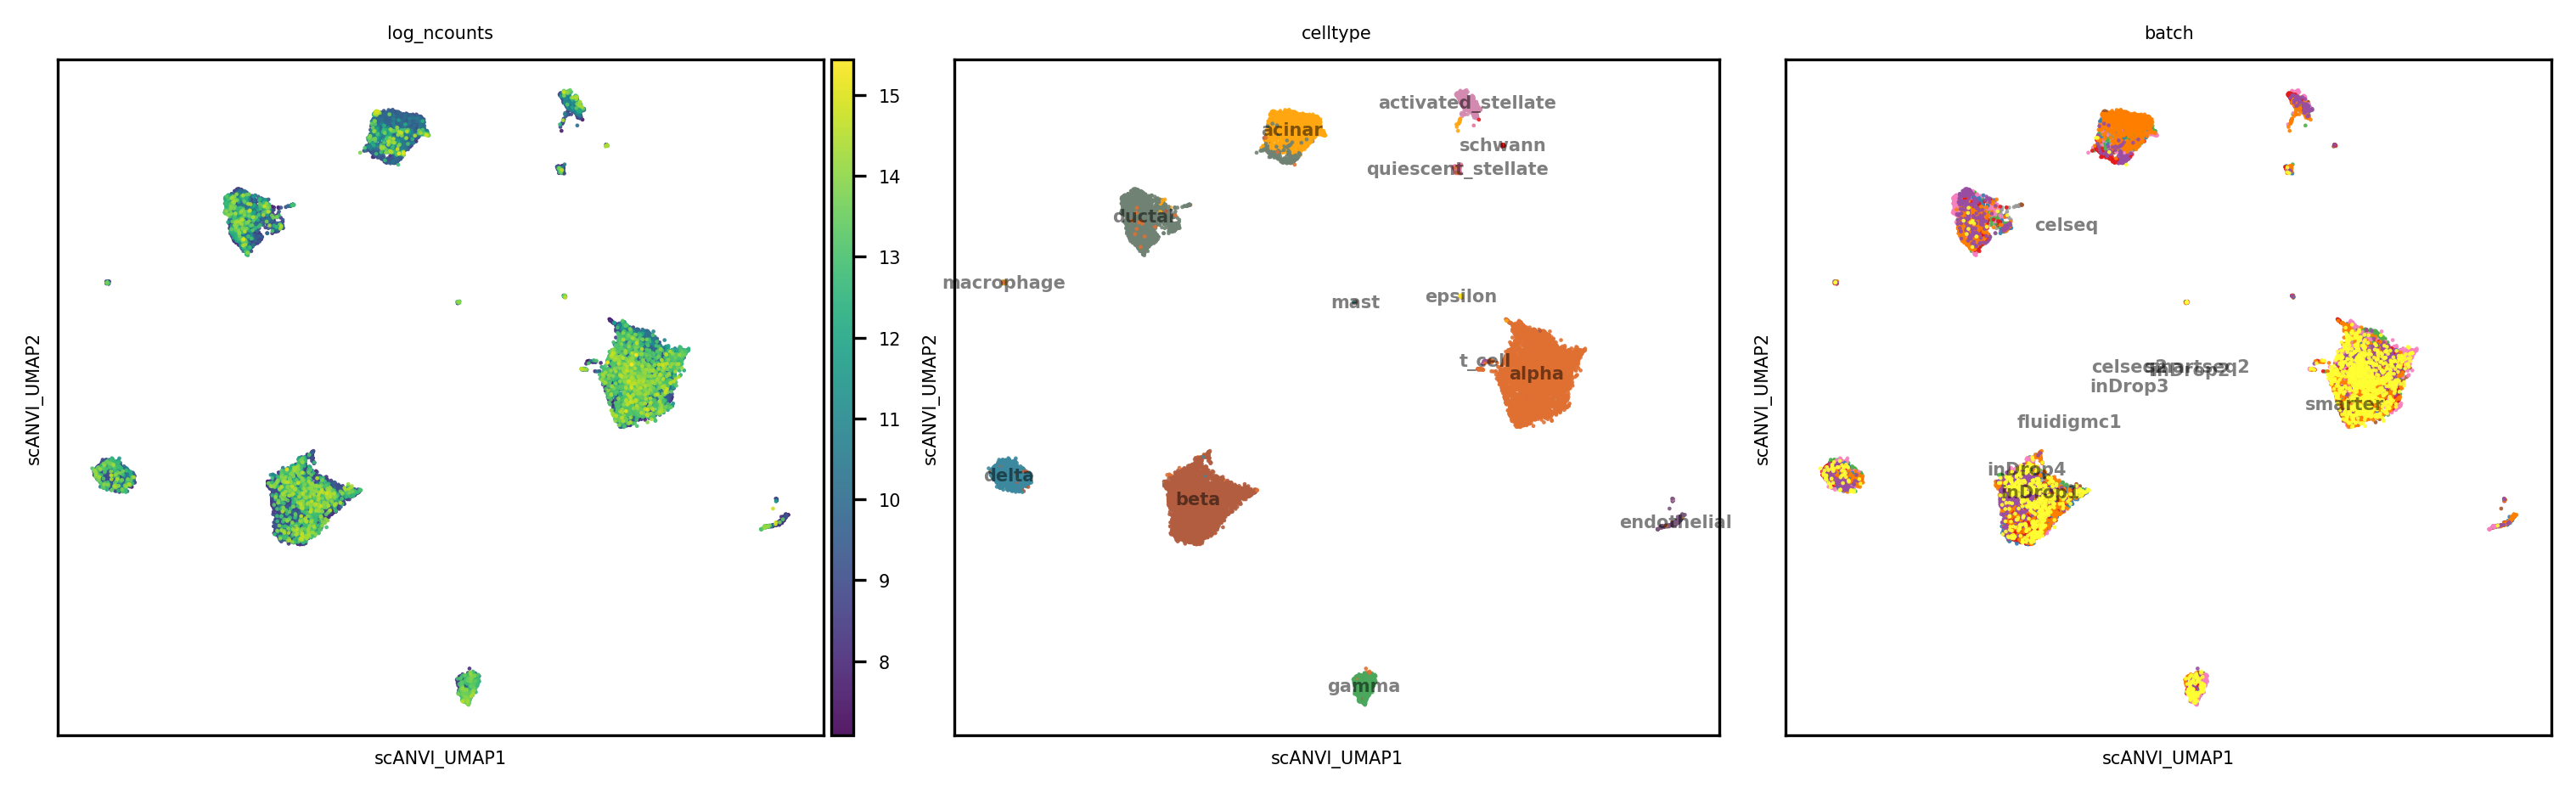

In [51]:
#ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'scANVI'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Concord

In [ ]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=15,
                      latent_dim=30,
                      p_intra_knn=0.3,
                      sampler_knn=300,
                      use_decoder=False,
                      p_intra_domain=1.0,
                      augmentation_mask_prob=0.5,
                      clr_temperature=0.3,
                      domain_key='batch', # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:01, 192.74it/s, loss=3.86]
Epoch 9 Training: 100%|██████████| 251/251 [00:00<00:00, 266.40it/s, loss=3.63]


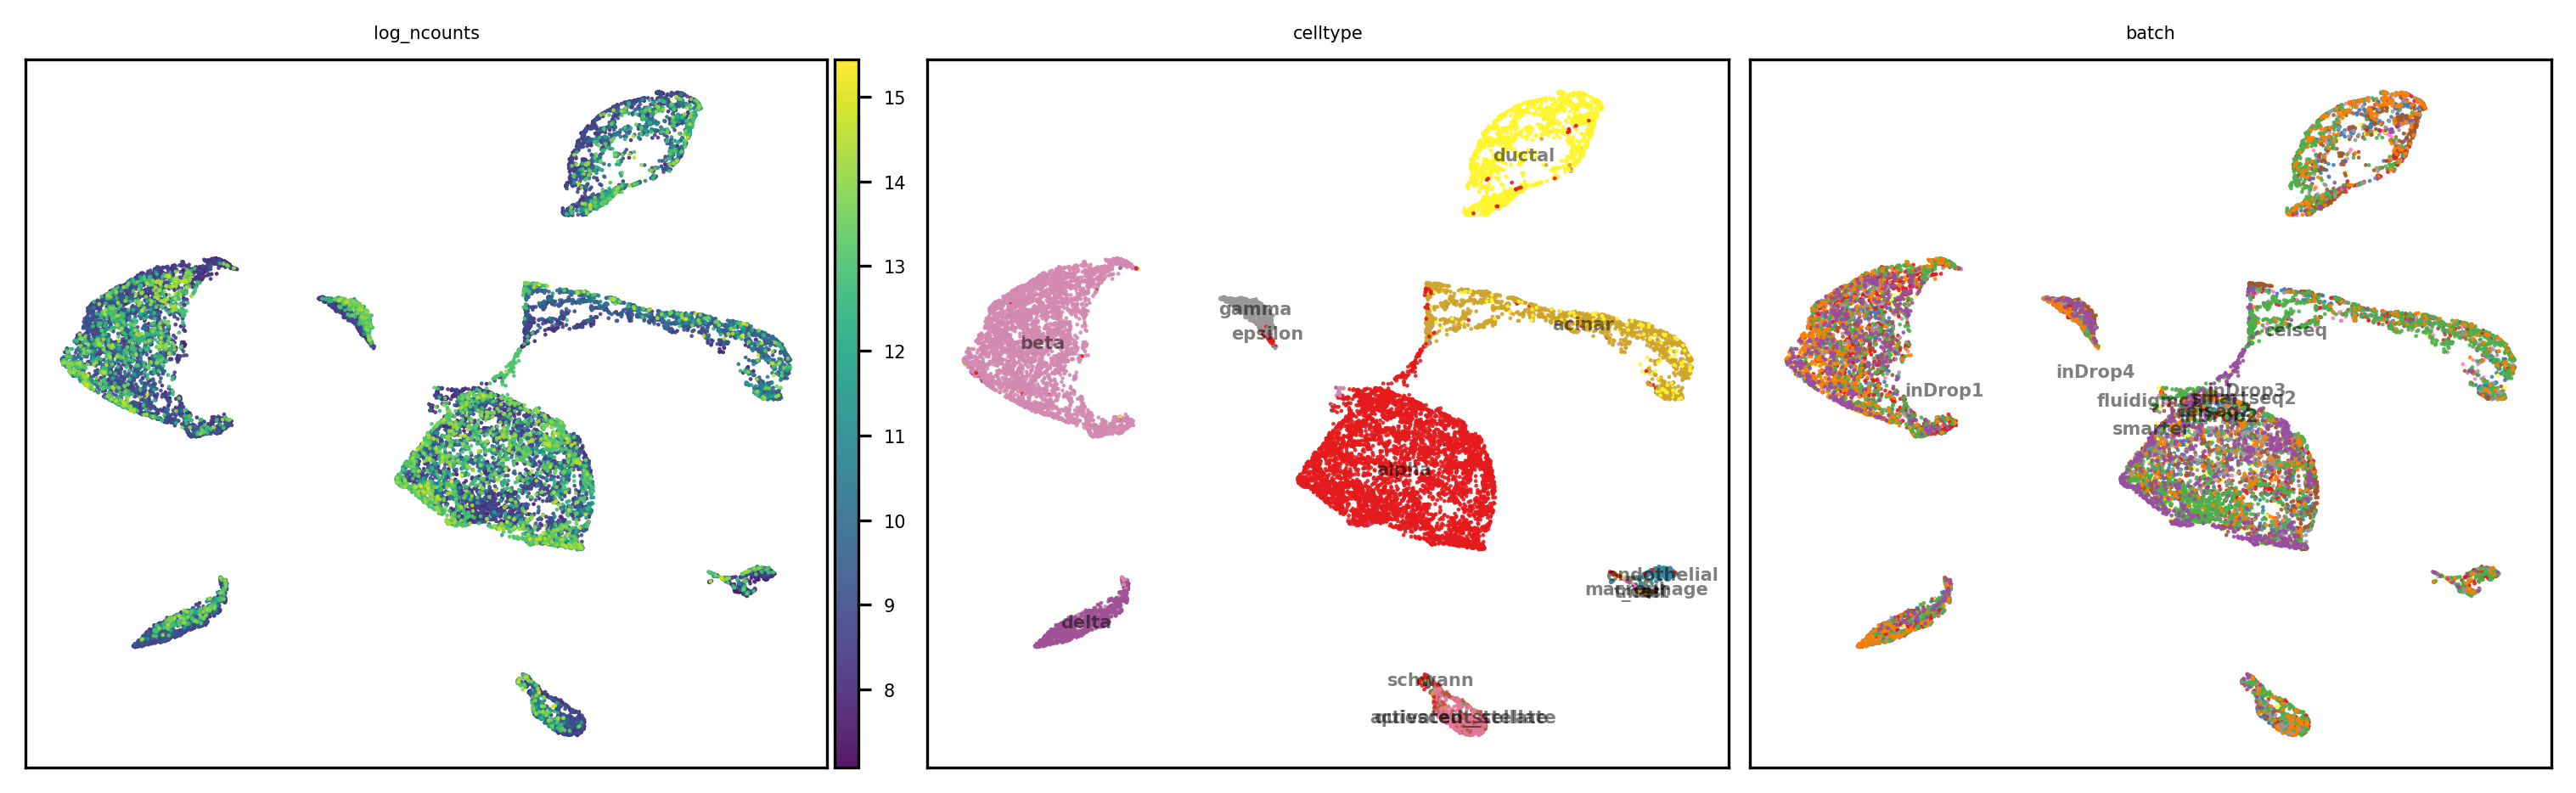

In [9]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
#output_key = 'Concord'
show_cols = ['log_ncounts', 'celltype', 'batch']
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

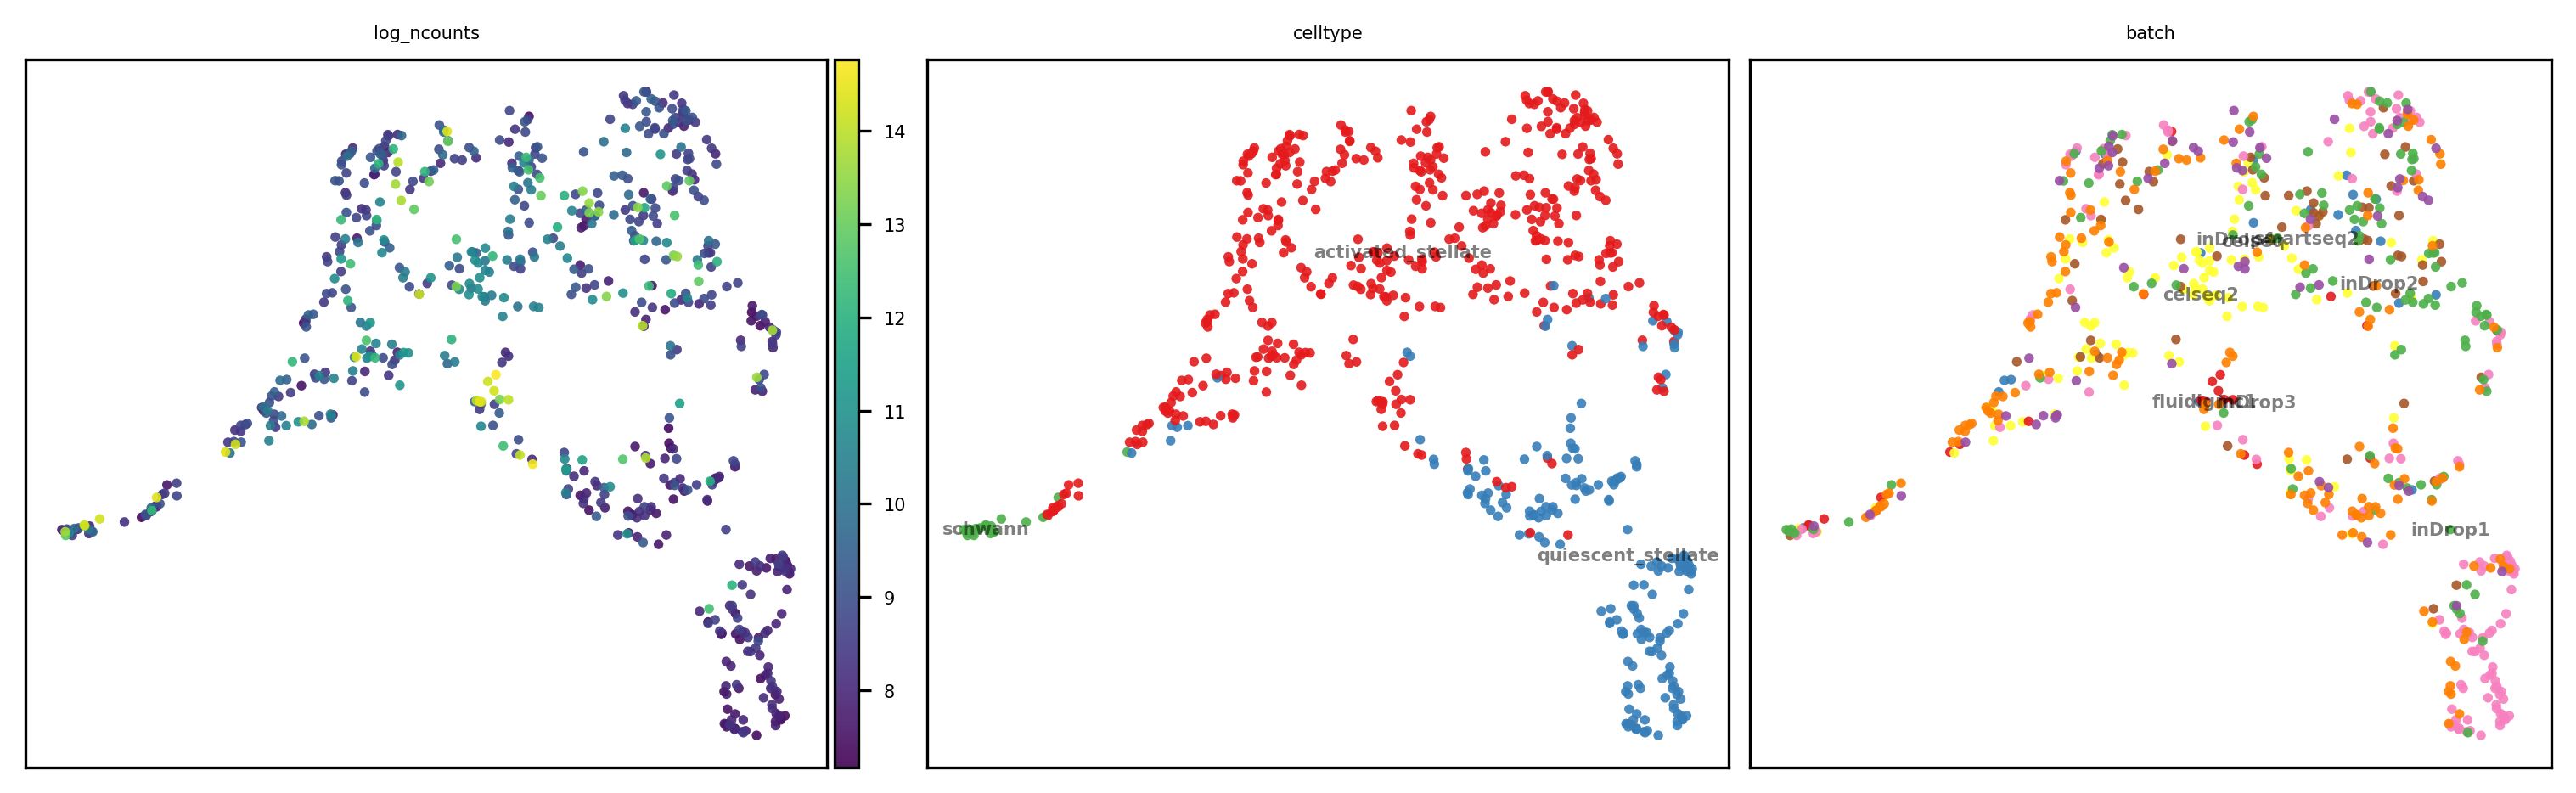

In [12]:
# Local zoom in umap
show_ctypes = ['schwann', 'activated_stellate', 'quiescent_stellate']
#show_ctypes = ['mast', 'macrophage', 't_cell']
adata_sub = adata[adata.obs['cell_type'].isin(show_ctypes)]
ccd.ul.run_umap(adata_sub, source_key=output_key, result_key='Concord_UMAP', n_components=2, n_epochs=500, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=seed, use_cuml=False)
show_emb = 'Concord_UMAP'
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=30, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png")

### Concord-decoder

In [ ]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=15,
                      latent_dim=30,
                      p_intra_knn=0.3,
                      sampler_knn=300,
                      use_decoder=True,
                      p_intra_domain=1.0,
                      augmentation_mask_prob=0.5,
                      clr_temperature=0.3,
                      domain_key='batch', # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-decoder'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:01, 143.08it/s, loss=4.59]
Epoch 14 Training: 100%|██████████| 251/251 [00:01<00:00, 146.94it/s, loss=3.54]


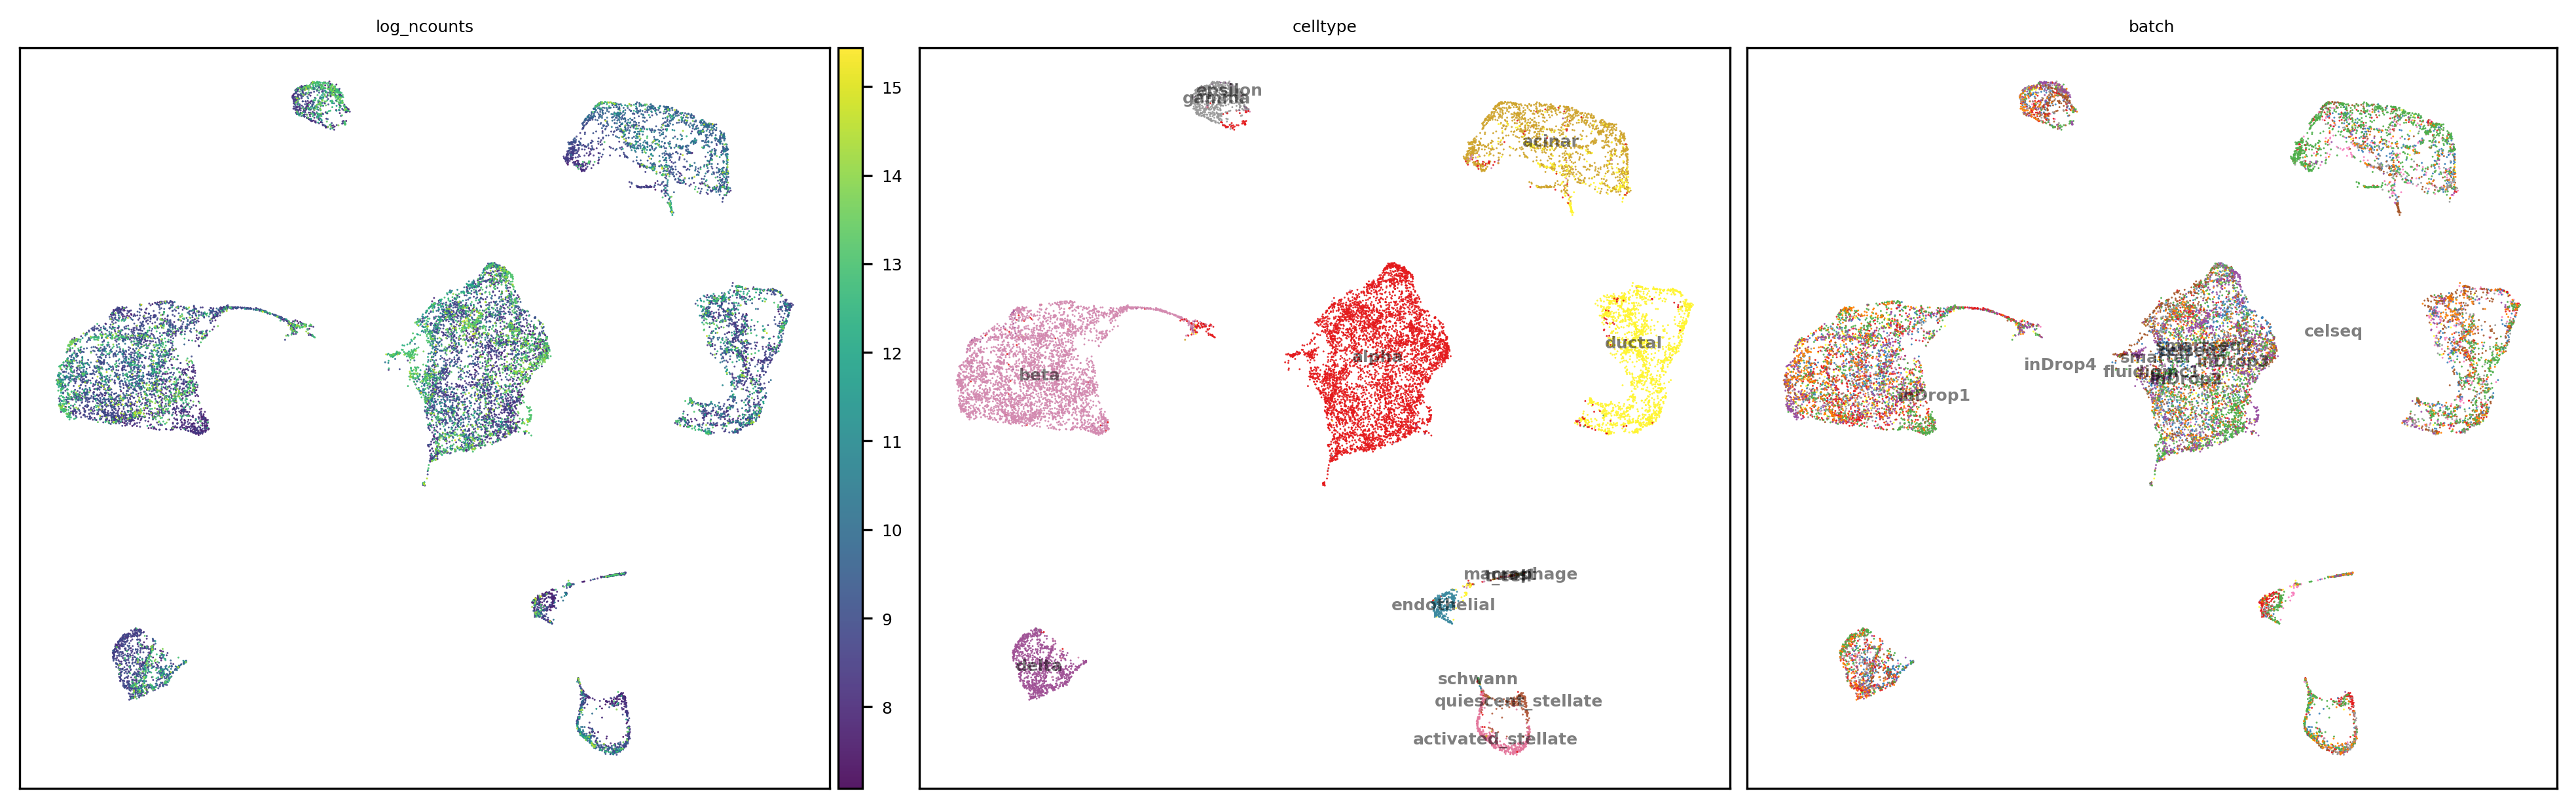

In [45]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,4), dpi=300, ncols=3, font_size=6, point_size=2, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

### Concord-ant

In [46]:

cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=15,
                      latent_dim=30,
                      p_intra_knn=0.3,
                      sampler_knn=300,
                      use_decoder=False,
                      use_classifier=True,
                      class_key = 'cell_type',
                      p_intra_domain=1.0,
                      augmentation_mask_prob=0.5,
                      clr_temperature=0.3,
                      domain_key='batch', # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-classifier'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 251it [00:01, 181.00it/s, loss=3.69]
Epoch 14 Training: 100%|██████████| 251/251 [00:01<00:00, 186.29it/s, loss=3.38]


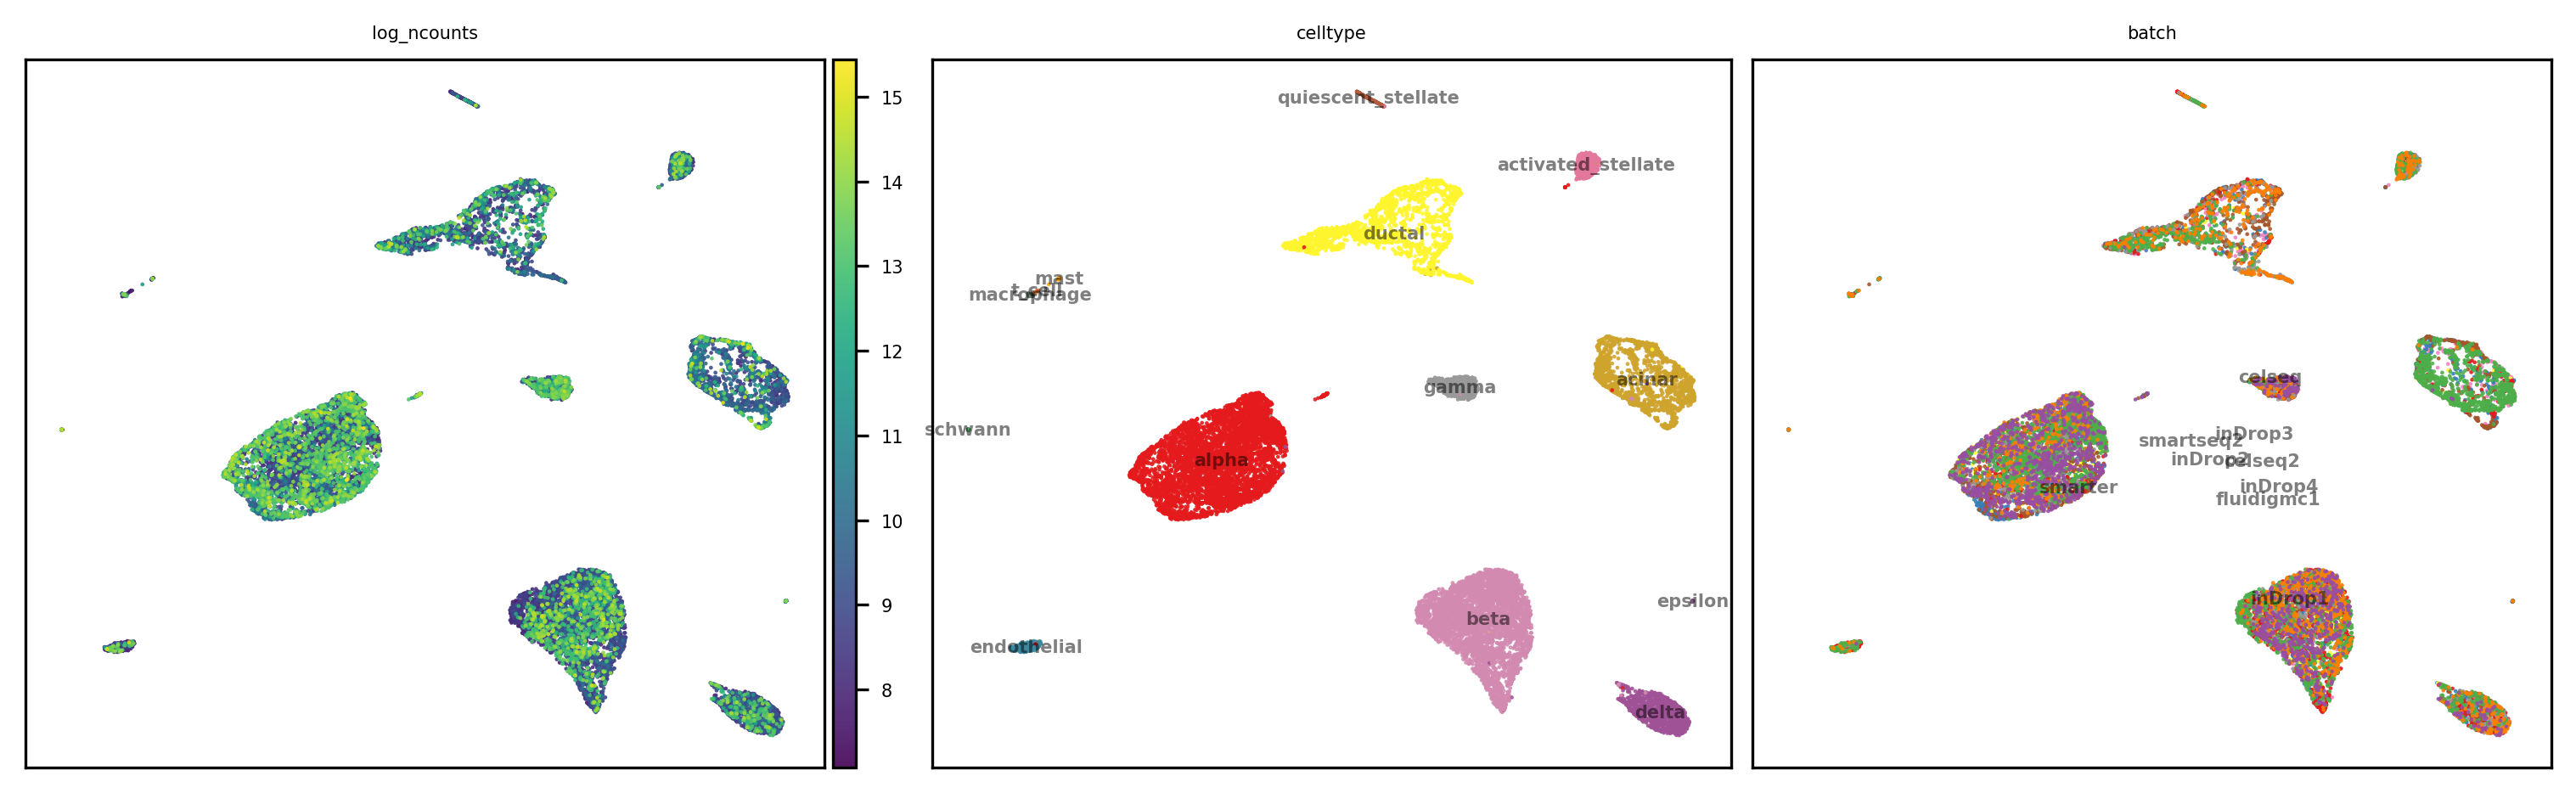

In [47]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png")

In [64]:
adata.obsm['Unintegrated_UMAP'] = adata.obsm['X_umap']

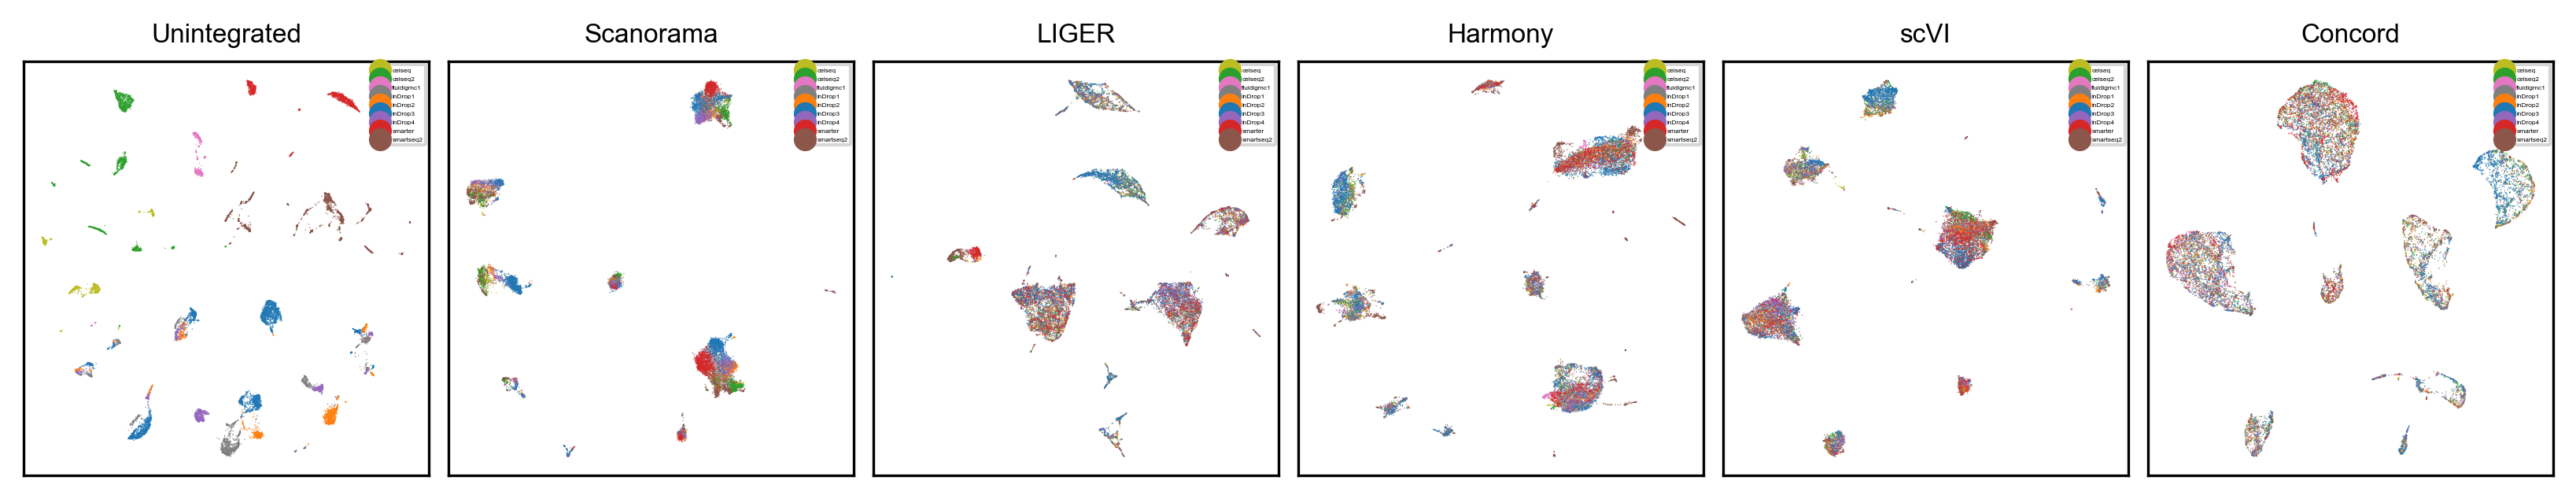

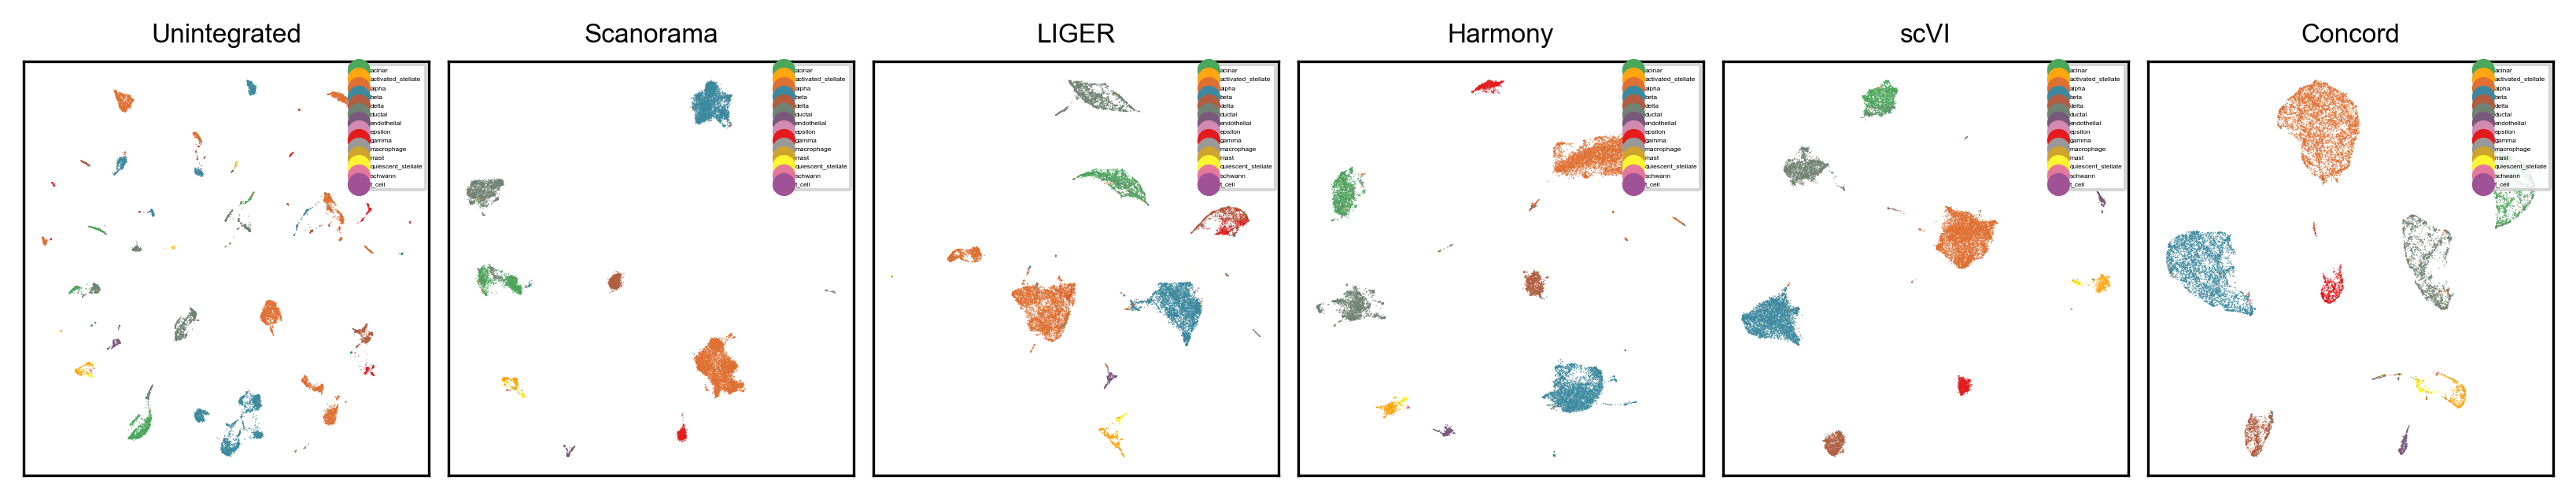

In [68]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['batch', 'celltype']
basis_types = ['UMAP']
font_size=8
point_size=0.5
alpha=0.8
show_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']
figsize=(1.8*len(show_keys),2)
ncols = len(show_keys)
nrows = 1
pal = {'batch':'tab10', 'celltype':'Set1'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1
legend_loc = 'upper right'

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        legend_loc=legend_loc,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix if legend_loc == None else file_suffix+'_legend',
        save_format='pdf'
    )


In [55]:
obsm_filename = save_dir / f"obsm_{file_suffix}.h5"
ccd.ul.save_obsm_to_hdf5(adata, obsm_filename)
print(f"Saved obsm to {obsm_filename}")

Saved obsm to ../save/dev_human_pancreas_benchmarking-Feb15/obsm_human_pancreas_benchmarking_Feb15-2105.h5


## Benchmarking

In [14]:
adata.obsm

AxisArrays with keys: Concord, Concord_UMAP, Concordant, Concordant-leiden, Concordant_UMAP, Harmony, Harmony_UMAP, LIGER, LIGER_UMAP, Scanorama, Scanorama_UMAP, Unintegrated, X_pca, X_umap, scANVI, scANVI_UMAP, scVI, scVI_UMAP

In [12]:
latent_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord', 'Concord-decoder', 'Concord-classifier', "scANVI"]

In [15]:
latent_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']

In [11]:
latent_keys = ['Concord','Concord-decoder', 'scVI']

In [16]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

Embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  17%|█▋        | 1/6 [00:20<01:42, 20.59s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  33%|███▎      | 2/6 [00:47<01:36, 24.08s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  50%|█████     | 3/6 [00:55<00:50, 16.75s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  67%|██████▋   | 4/6 [01:10<00:32, 16.18s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  83%|████████▎ | 5/6 [01:17<00:12, 12.88s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings: 100%|██████████| 6/6 [01:24<00:00, 14.09s/it]


In [17]:
import pandas as pd
show_keys = ["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", 'Concord']
scib_scores = bm.get_results(min_max_scale=False)
scib_scores = scib_scores.loc[show_keys+['Metric Type']]
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

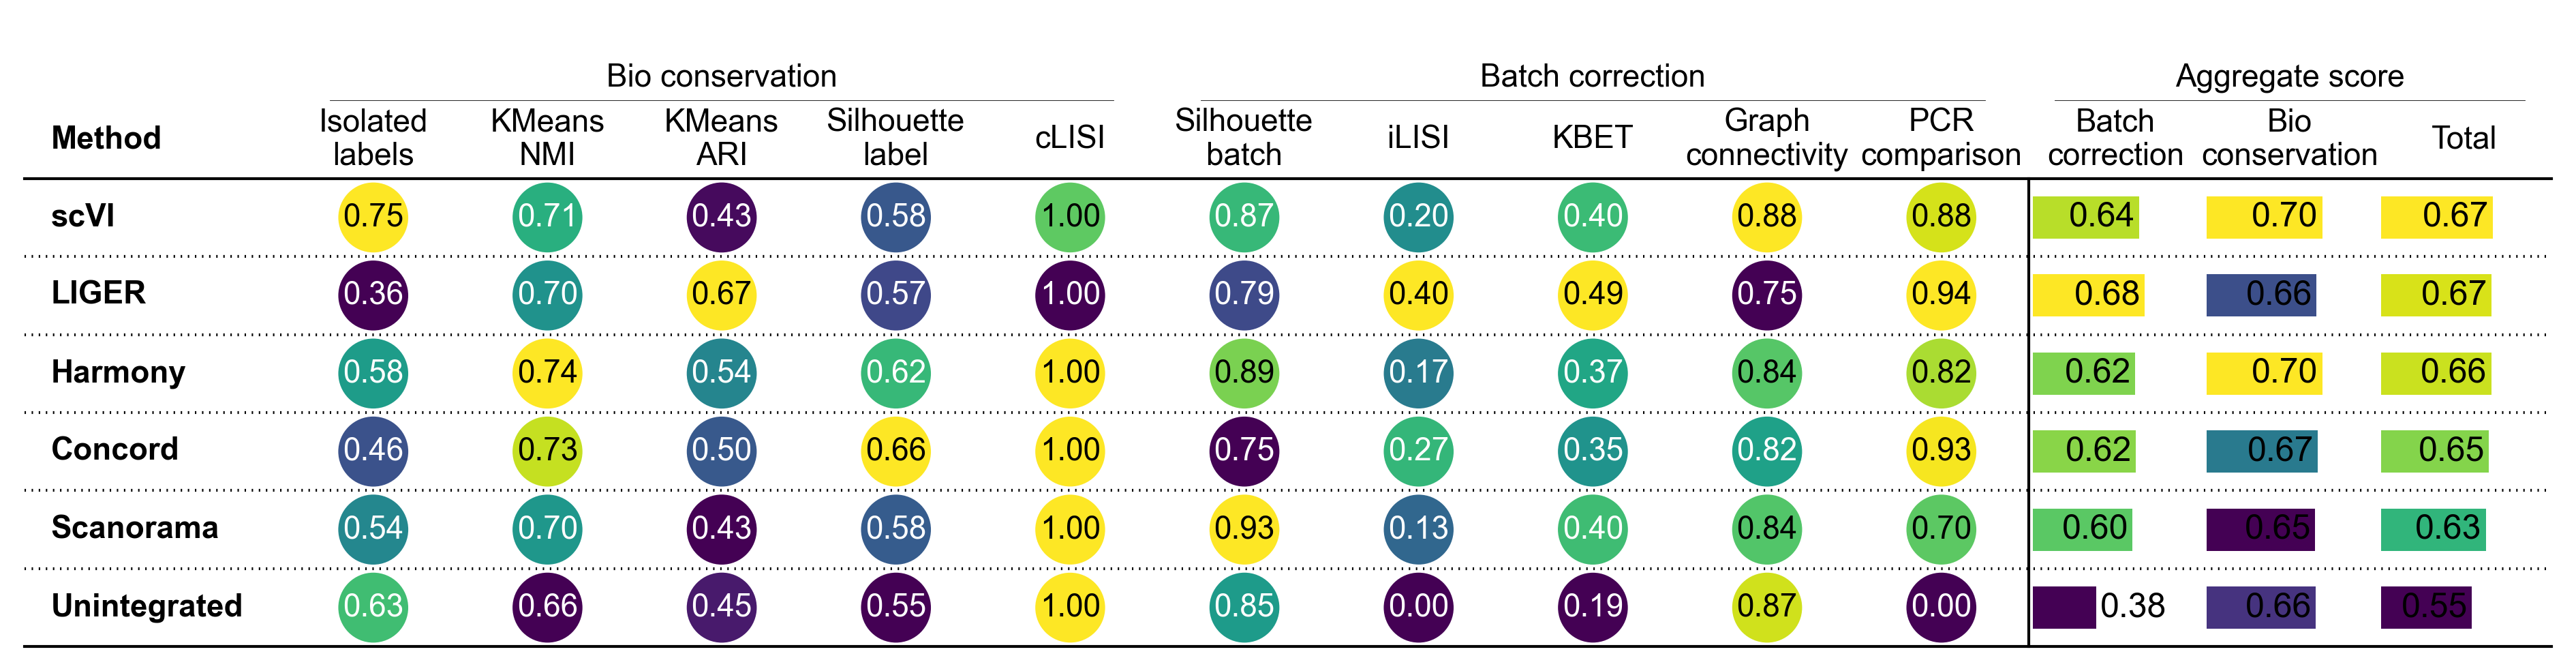

In [18]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(scib_scores, pal='viridis', pal_agg='viridis', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 4), dpi=300)